<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evaluation-of-metadata-predictions" data-toc-modified-id="Evaluation-of-metadata-predictions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Evaluation of metadata predictions</a></span></li><li><span><a href="#Set-up" data-toc-modified-id="Set-up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set-up</a></span><ul class="toc-item"><li><span><a href="#Load-necessary-packages" data-toc-modified-id="Load-necessary-packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load necessary packages</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Load-embedding-model" data-toc-modified-id="Load-embedding-model-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Load embedding model</a></span></li><li><span><a href="#Create-dataframe" data-toc-modified-id="Create-dataframe-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Create dataframe</a></span></li></ul></li></ul></li><li><span><a href="#Prediction-performance" data-toc-modified-id="Prediction-performance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prediction performance</a></span><ul class="toc-item"><li><span><a href="#Covert-to-lower-case-for-better-comparison" data-toc-modified-id="Covert-to-lower-case-for-better-comparison-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Covert to lower case for better comparison</a></span></li><li><span><a href="#Overall-prediction-stats" data-toc-modified-id="Overall-prediction-stats-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Overall prediction stats</a></span></li><li><span><a href="#Exact-matches" data-toc-modified-id="Exact-matches-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exact matches</a></span></li><li><span><a href="#Contained-within" data-toc-modified-id="Contained-within-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Contained within</a></span></li><li><span><a href="#Cosine-similarity" data-toc-modified-id="Cosine-similarity-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Cosine similarity</a></span></li><li><span><a href="#-Table-1--accuracy-of-prediction" data-toc-modified-id="-Table-1--accuracy-of-prediction-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span><font color="red"> Table 1 </font> accuracy of prediction</a></span><ul class="toc-item"><li><span><a href="#BLEU-scoring" data-toc-modified-id="BLEU-scoring-3.6.1"><span class="toc-item-num">3.6.1&nbsp;&nbsp;</span>BLEU scoring</a></span></li><li><span><a href="#Levenshtein-distance" data-toc-modified-id="Levenshtein-distance-3.6.2"><span class="toc-item-num">3.6.2&nbsp;&nbsp;</span>Levenshtein distance</a></span></li></ul></li></ul></li><li><span><a href="#Examples-of-misses?" data-toc-modified-id="Examples-of-misses?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Examples of misses?</a></span></li></ul></div>

# Evaluation of metadata predictions
Adam Klie<br>
12/08/2019<br>
Script to evaluate predictions

# Set-up

## Load necessary packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import Levenshtein

from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


## Load data

### Load embedding model

In [2]:
nlp = spacy.load('../data/wikipedia-pubmed-and-PMC-w2v')

/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


### Create dataframe

In [3]:
model_iter = '11_class'

In [4]:
grouping = pd.read_csv('../results/embedding/{model}/0.8_entity_merging.csv'.format(model=model_iter), index_col=0)

In [5]:
groups = grouping[grouping["I"] == 0]["GroupName"].values

In [7]:
import warnings
warnings.filterwarnings('ignore')
validation_data_count = {}
merged = pd.DataFrame()
total_count = 0
for group in groups:
    group_dir = group.replace(' ', '_')
    group_dir = group_dir.replace('/', '_')
    #if group == "Platform":
    #    continue
    predicted_df = pd.read_pickle(
    '../results/prediction/{mymodel}/{myclass}_prediction.pickle'.format(mymodel = model_iter, 
                                                                          myclass = group_dir))
    class_validation = pd.read_pickle(
    '../results/validation/{mymodel}/{myclass}_validation_values.pickle'.format(mymodel = model_iter, 
                                                                                myclass = group_dir))
    validation_data = pd.read_pickle(
    '../results/validation/{mymodel}/{myclass}_validation_set.pickle'.format(mymodel = model_iter, 
                                                                             myclass = group_dir))
    class_df = predicted_df[predicted_df['predicted'] == group]
    print(group, ":", validation_data.shape[0], ",", class_df.shape[0])
    validation_data_count[group] = validation_data.shape[0]
    tmp_df = class_validation.loc[class_df['srs'].values]
    tmp_df = tmp_df.loc[~tmp_df.index.duplicated(keep = 'first')]
    class_df['actual'] = tmp_df.loc[class_df['srs'].values]['value'].values
    merged = pd.concat([merged, class_df], axis=0)
    total_count = total_count + validation_data.shape[0]

Species : 1000 , 855
Strain : 1000 , 295
Cell type : 702 , 144
Genotype : 595 , 130
Condition/Disease : 122 , 23
Tissue : 1000 , 237
Sex : 190 , 4
Age : 1000 , 224
Data type : 78 , 12
Platform : 275 , 30
Protocol : 18 , 0


# Prediction performance

## Covert to lower case for better comparison

In [8]:
merged["token"] = merged["token"].str.lower()
merged["actual"] = merged["actual"].str.lower()

## Overall prediction stats

In [9]:
predicted_count = merged.shape[0]
print(('%d/%d (%.2f%%) predicted' % 
       (predicted_count, total_count, predicted_count/total_count*100)))

1954/5980 (32.68%) predicted


In [10]:
merged["predicted"].value_counts()

Species              855
Strain               295
Tissue               237
Age                  224
Cell type            144
Genotype             130
Platform              30
Condition/Disease     23
Data type             12
Sex                    4
Name: predicted, dtype: int64

In [11]:
# missing_df = class_validation[~class_validation.index.isin(class_df['srs'].values)]
# missing = validation_data[~validation_data.index.get_level_values(0).isin(class_df['srs'].values)]
# if missing_df.shape[0] == len(missing):  # if there are not duplicate srs predictions
#     missing_df['TITLE'] = missing.values

In [12]:
# missing_df.to_csv(
#     '../results/{model}/predictions/{myclass}_missing.csv'.format(model = model_iter, myclass = predicted_class))

## Exact matches

In [13]:
merged["exact_match"] = merged['token'] == merged['actual']

In [14]:
num_correct = merged["exact_match"].sum()
print(('%d/%d (%.2f%%) exact matches' % 
       (num_correct, predicted_count, num_correct/predicted_count*100)))

466/1954 (23.85%) exact matches


In [15]:
class_exact = merged.groupby(['predicted', 'exact_match']).size().reset_index().pivot(index='predicted', 
                                                                                      columns='exact_match')
class_exact

0       
exact_match        False  True 
predicted                      
Age                186.0   38.0
Cell type          142.0    2.0
Condition/Disease   10.0   13.0
Data type           12.0    NaN
Genotype           108.0   22.0
Platform            30.0    NaN
Sex                  4.0    NaN
Species            528.0  327.0
Strain             273.0   22.0
Tissue             195.0   42.0

In [16]:
merged.groupby('exact_match').mean()["score"]

exact_match
False    0.404395
True     0.531036
Name: score, dtype: float32

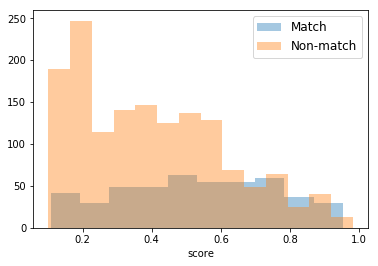

In [17]:
sns.distplot(merged[merged['exact_match'] == True]['score'], label='Match', kde=False)
sns.distplot(merged[merged['exact_match'] == False]['score'], label='Non-match', kde=False)
plt.legend(prop={'size': 12})

In [18]:
# exact_correct_df.to_csv(
#     '../results/{model}/predictions/{myclass}_correct.csv'.format(model = model_iter, myclass = predicted_class))
# exact_incorrect_df.to_csv(
#     '../results/{model}/predictions/{myclass}_incorrect.csv'.format(model = model_iter, myclass = predicted_class))

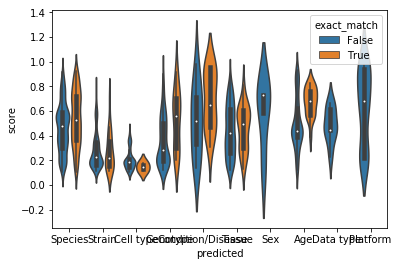

In [19]:
ax = sns.violinplot(x='predicted', y='score', data=merged, hue='exact_match')

## Contained within

In [20]:
def within(x):
    if (x["actual"] in x['token']) or (x['token'] in x["actual"]):
        return True
    else:
        return False

In [21]:
merged['within'] = merged.apply(within, axis=1)
count = merged['within'].sum()

In [22]:
print(('%d/%d (%.2f%%) of predicted contained in actual' % 
       (count, predicted_count, count/predicted_count*100)))

1330/1954 (68.07%) of predicted contained in actual


In [23]:
class_contain = merged.groupby(['predicted', 'within']).size().reset_index().pivot(index='predicted', 
                                                                                      columns='within')
class_contain.columns = ["non-match", "match"]
class_contain["fraction_match"] = class_contain["match"]/class_contain.sum(axis=1)

In [24]:
class_contain

non-match  match  fraction_match
predicted                                          
Age                    160.0   64.0        0.285714
Cell type               90.0   54.0        0.375000
Condition/Disease        3.0   20.0        0.869565
Data type               12.0    NaN             NaN
Genotype                80.0   50.0        0.384615
Platform                21.0    9.0        0.300000
Sex                      3.0    1.0        0.250000
Species                 95.0  760.0        0.888889
Strain                  54.0  241.0        0.816949
Tissue                 106.0  131.0        0.552743

## Cosine similarity

In [25]:
predicted_docs = nlp.pipe(merged['token'].tolist())
predicted_vectors = np.array([doc.vector for doc in predicted_docs])

actual_docs = nlp.pipe(merged['actual'].tolist())
actual_vectors = np.array([doc.vector for doc in actual_docs])

In [26]:
similarities = []
for i in range(len(predicted_vectors)):
    cosine_sim = cosine_similarity(predicted_vectors[i].reshape(1,200), actual_vectors[i].reshape(1,200))
    similarities.append(float(cosine_sim))

In [27]:
merged["cosine_similarity"] = similarities

(array([340.,  98.,  46.,  36.,  51.,  42.,  88., 121., 198., 934.]),
 array([-0.04997848,  0.0550194 ,  0.16001727,  0.26501514,  0.37001301,
         0.47501088,  0.58000875,  0.68500662,  0.7900045 ,  0.89500237,
         1.00000024]),
 <a list of 10 Patch objects>)

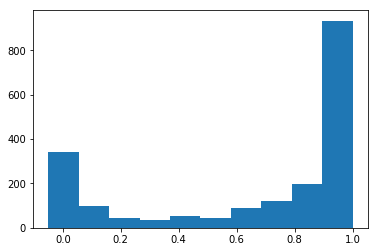

In [28]:
plt.hist(merged['cosine_similarity'])

In [29]:
sim_threshold = 0.7
merged["cosine_match"] = merged['cosine_similarity'].values > sim_threshold
num_sim = merged["cosine_match"].sum()

In [30]:
print(('%d/%d (%.2f%%) Predicted with cosine similarity greater than %.1f\n' 
                     % (num_sim, predicted_count, num_sim/predicted_count*100, sim_threshold)))

1245/1954 (63.72%) Predicted with cosine similarity greater than 0.7



In [31]:
class_cosine = merged.groupby(['predicted', 'cosine_match']).size().reset_index().pivot(index='predicted', 
                                                                                        columns='cosine_match')
class_cosine.columns = ["non-match", "match"]
class_cosine["fraction_match"] = class_cosine["match"]/class_cosine.sum(axis=1)

In [32]:
class_cosine

non-match  match  fraction_match
predicted                                          
Age                    121.0  103.0        0.459821
Cell type               80.0   64.0        0.444444
Condition/Disease        2.0   21.0        0.913043
Data type                2.0   10.0        0.833333
Genotype                65.0   65.0        0.500000
Platform                19.0   11.0        0.366667
Sex                      NaN    4.0        1.000000
Species                 56.0  799.0        0.934503
Strain                 269.0   26.0        0.088136
Tissue                  95.0  142.0        0.599156

In [33]:
title_counts = pd.DataFrame(pd.Series(validation_data_count), columns=['titles'])

## <font color='red'> Table 1 </font> accuracy of prediction

In [34]:
merged["either"] = merged["within"] | merged["cosine_match"]

In [35]:
class_either = merged.groupby(['predicted', 'either']).size().reset_index().pivot(index='predicted', 
                                                                                        columns='either')
class_either.columns = ["non-match", "match"]
class_either["either_match"] = class_either["match"]/class_either.sum(axis=1)

In [36]:
class_either

non-match  match  either_match
predicted                                        
Age                    118.0  106.0      0.473214
Cell type               76.0   68.0      0.472222
Condition/Disease        1.0   22.0      0.956522
Data type                2.0   10.0      0.833333
Genotype                49.0   81.0      0.623077
Platform                19.0   11.0      0.366667
Sex                      NaN    4.0      1.000000
Species                 44.0  811.0      0.948538
Strain                  53.0  242.0      0.820339
Tissue                  86.0  151.0      0.637131

In [37]:
table1 = class_cosine.merge(pd.DataFrame(merged["predicted"].value_counts()), left_index=True, right_index=True)
table1 = table1.merge(title_counts, left_index=True, right_index=True)
table1 = table1.merge(class_contain, left_index=True, right_index=True, suffixes=['_cosine', '_contain'])
table1 = table1.merge(class_either, left_index=True, right_index=True, suffixes=['_either', '_either'])

In [38]:
table1["fraction_predicted"] = table1['predicted']/table1['titles']

In [39]:
table1 = table1[['titles', 'predicted', 'fraction_predicted', 
        'match_cosine', 'fraction_match_cosine', 'match_contain', 'fraction_match_contain', 'match', 'either_match']]

In [40]:
table1['percent_correct'] = table1[["fraction_match_cosine", "fraction_match_contain"]].max(axis=1)

In [48]:
table1

titles  predicted  fraction_predicted  match_cosine  \
Age                  1000        224            0.224000         103.0   
Cell type             702        144            0.205128          64.0   
Condition/Disease     122         23            0.188525          21.0   
Data type              78         12            0.153846          10.0   
Genotype              595        130            0.218487          65.0   
Platform              275         30            0.109091          11.0   
Sex                   190          4            0.021053           4.0   
Species              1000        855            0.855000         799.0   
Strain               1000        295            0.295000          26.0   
Tissue               1000        237            0.237000         142.0   

                   fraction_match_cosine  match_contain  \
Age                             0.459821           64.0   
Cell type                       0.444444           54.0   
Condition/Disease               0.913043           20.0   
Data type                       0.833333            NaN   
Genotype                        0.500000           50.0   
Platform                        0.366667            9.0   
Sex                             1.000000            1.0   
Species                         0.934503          760.0   
Strain                          0.088136          241.0   
Tissue                          0.599156          131.0   

                   fraction_match_contain  match  either_match  \
Age                              0.285714  106.0      0.473214   
Cell type                        0.375000   68.0      0.472222   
Condition/Disease                0.869565   22.0      0.956522   
Data type                             NaN   10.0      0.833333   
Genotype                         0.384615   81.0      0.623077   
Platform                         0.300000   11.0      0.366667   
Sex                              0.250000    4.0      1.000000   
Species                          0.888889  811.0      0.948538   
Strain                           0.816949  242.0      0.820339   
Tissue                           0.552743  151.0      0.637131   

                   percent_correct  
Age                       0.459821  
Cell type                 0.444444  
Condition/Disease         0.913043  
Data type                 0.833333  
Genotype                  0.500000  
Platform                  0.366667  
Sex                       1.000000  
Species                   0.934503  
Strain                    0.816949  
Tissue                    0.599156

In [171]:
table1.to_csv('../doc/revision/reviewer_3/1_grams_comment_3.csv', index=True)

### BLEU scoring

In [153]:
def bleu1(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(1, 0, 0, 0), smoothing_function=smoother.method1)

def bleu4(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(0, 0, 0, 1), smoothing_function=smoother.method1)

In [154]:
smoother = SmoothingFunction()
table1["BLUE1"] = table1.apply(bleu1, axis=1)
table1["BLUE4"] = table1.apply(bleu4, axis=1)

KeyError: ('actual', 'occurred at index Age')

### Levenshtein distance

In [155]:
def levenshtein(x):
    return Levenshtein.distance(x["predicted"], x["actual"])

In [156]:
table1["levenshtein"] = table1.apply(levenshtein, axis=1)

KeyError: ('actual', 'occurred at index Age')

# Examples of misses?

In [50]:
missed = merged[~merged["either"]]
missed_df = missed[["predicted", "orig_text","recovered_txt", "actual"]]

In [51]:
missed_df.to_csv('../doc/tables/Supplementary/revision/Supp_Table3.csv')

In [60]:
((missed_df.actual.str.count(" ") + 1) == 1).sum()

217

In [61]:
missed_df

predicted                                          orig_text  \
2544    Species                  32% Streptococcus mutans UA159 69   
2536    Species                       68% Lactobacillus casei 4646   
2535    Species  A cucumber genomic variation map reveals impac...   
2403    Species  Bulk soils compared rhizosphere communities pl...   
2400    Species                 CBo1 isolated gut Bactrocera oleae   
2256    Species        Endophytic isolate branches Citrus sinensis   
2245    Species  Environmental/Metagenome sample subarctic root...   
2066    Species             Generic sample Fusobacterium nucleatum   
2051    Species  Generic sample Homo sapiens respiratory syncyt...   
2023    Species                    Generic sample Mimulus guttatus   
1658    Species                  Human respiratory syncytial virus   
1655    Species                        Hyphomicrobium facile subsp   
1620    Species            Ip394_Japanese crested ibis (founder E)   
1607    Species  Lathyrus pratensis clone 275 reared Lathyrus p...   
1533    Species  MIMARKS Survey related sample Borrelia burgdor...   
1531    Species  MIMARKS Survey related sample Borrelia burgdor...   
1532    Species  MIMARKS Survey related sample Borrelia burgdor...   
1534    Species  MIMARKS Survey related sample Borrelia burgdor...   
1512    Species                                Medicago truncatula   
1421    Species  Mycobacterium lepromatosis red squirrel M1960/...   
1301    Species  Phylogenomic characterization causative strain...   
1271    Species  Picea engelmannii cultivated The Arboretum Hor...   
1245    Species  Plant DNA metabarcoding data uncleaned surface...   
1244    Species  Plant DNA metabarcoding data uncleaned surface...   
1243    Species  Plant DNA metabarcoding data uncleaned surface...   
1123    Species  Root tissue samples Caladium hortulanum (MissM...   
1117    Species         SYNE2/ESR2A CALM1 loci Clupea pallisii PH3   
1112    Species         SYNE2/ESR2A CALM1 loci Clupea pallisii PH5   
812     Species                     Small RNAs Miscanthus rhizomes   
791     Species  Stable isotope probing targeting methane-utili...   
...         ...                                                ...   
261         Age     Vaginal microbiota associated preterm delivery   
262         Age     Vaginal microbiota associated preterm delivery   
187         Age                                  Zeitgeber Time 00   
185         Age                                  Zeitgeber Time 18   
176         Age  bisulfite treated genomic DNA old sun exposed ...   
164         Age   cinerea B9 different inoculation time treatments   
130         Age                     five 5w old individuals (male)   
12          Age                                       time point 2   
2           Age  zebrafish normal developmental age 72hpf contr...   
222   Data type  Non-tumor DNA sample human male participant db...   
39    Data type  Tumor DNA sample human male participant dbGaP ...   
633    Platform                       16S rDNA amplicon patient 11   
629    Platform                        16S rDNA amplicon patient 5   
625    Platform                            16S rRNA control root 3   
623    Platform                         16S rRNA mycorrhiza leaf 1   
619    Platform  16S rRNA sequences fecal bacterial community C...   
363    Platform  Mouse fecal sample VLP-purification 454 Sequen...   
364    Platform  Mouse fecal sample VLP-purification 454 Sequen...   
278    Platform  Pyrosequencing 16S rRNA amplicons pig gastroin...   
280    Platform  Pyrosequencing 16S rRNA amplicons pig gastroin...   
279    Platform  Pyrosequencing 16S rRNA amplicons pig gastroin...   
120    Platform          SAG SCGC_AB-704-M06 partial SSU rRNA gene   
117    Platform          SAG SCGC_AB-704-N13 partial SSU rRNA gene   
114    Platform          SAG SCGC_AB-706-C03 partial SSU rRNA gene   
111    Platform          SAG SCGC_AB-706-E02 partial SSU rRNA gene   
108    Platform 